# Self Learning

1. see the **exp data as unlabeled data**, and then we use the xgboost model which trained on dft set to label the exp data.
2. discard items that differ significantly(**Δ>1**) between dft model prediction and real value.
3. use the labeled exp data and dft data together to train model and then label the exp data again.
4. Repeat the above steps.

In [61]:
import os
import sys
import pandas as pd
import numpy as np
np.random.seed(42)
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [62]:
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False


In [63]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [64]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

In [65]:
dft_train_X.shape, exp_train_X.shape, mixed_test_X.shape, mixed_test_y.shape

((8275, 64), (2545, 64), (1170, 64), (1170,))

In [66]:
from xgboost import XGBRegressor
from sklearn.base import clone

In [67]:
xgb = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
dft_model = SingleModel(clone(xgb), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training completed!


In [68]:
# 1. total dft train data 
self_learn_model = dft_model
eventually_model = None
# 
LARGE_ERROR = 0.4
SMALL_ERROR_RATE = 0.95
DFT_RATIO = 0.5
# track
iteration_metrics = []  

for i in range(100):
    pred_y = self_learn_model.predict(exp_train_X)

    # discard the samples with large error
    # get the samples with small error  
    small_error_index = (np.abs(pred_y - exp_train_y) <= LARGE_ERROR)
    small_error_X = exp_train_X[small_error_index]
    
    ############KEY########################
    small_error_y = (pred_y[small_error_index]*DFT_RATIO) + (exp_train_y[small_error_index]*(1-DFT_RATIO))

    # 
    if small_error_X.shape[0] > SMALL_ERROR_RATE*len(exp_train_X):
        print('The number of small error samples is greater than the threshold.')
        eventually_model = self_learn_model
        break
    # log
    print(f'[ Iteration {i} ]: ')
    print(f'small error samples: {small_error_X.shape[0]}')
    # save metrics
    test_metrics = self_learn_model.evaluate(mixed_test_X, mixed_test_y, fig_show=False)
    iteration_metrics.append({
        'iteration': i,
        'small_error_samples': small_error_X.shape[0],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'model': self_learn_model
    })

    # early stopping
    if i > 0 and iteration_metrics[-1]['test_rmse'] >= iteration_metrics[-2]['test_rmse']:
        consecutive_no_improvement += 1
    else:
        consecutive_no_improvement = 0

    if consecutive_no_improvement >= 8:
        print(f"Early stopping at iteration {i} due to no improvement")
        eventually_model = self_learn_model
        break

    # train the model on the small error samples and exp samples
    train_X = pd.concat([small_error_X, dft_train_X], axis=0, ignore_index=True)
    train_y = pd.concat([small_error_y, dft_train_y], axis=0, ignore_index=True)

    self_learn_model = SingleModel(clone(xgb), random_state=RANDOM_SEED)
    self_learn_model.train(train_X, train_y)

if eventually_model is None:
    eventually_model = self_learn_model
# 使用具有最小RMSE的模型进行预测
best_model = min(iteration_metrics, key=lambda x: x['test_rmse'])['model']



[ Iteration 0 ]: 
small error samples: 921

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4691 RMSE: 0.6067 MAE: 0.4536 MAPE: 883.5711%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.8s
Model training completed!
[ Iteration 1 ]: 
small error samples: 1060

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4872 RMSE: 0.5962 MAE: 0.4419 MAPE: 937.3162%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   3.9s
Model training completed!
[ Iteration 2 ]: 
small error samples: 1160

Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.4914 RMSE: 0.5938 MAE: 0.4353 MAPE: 1133.9294%
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing mod

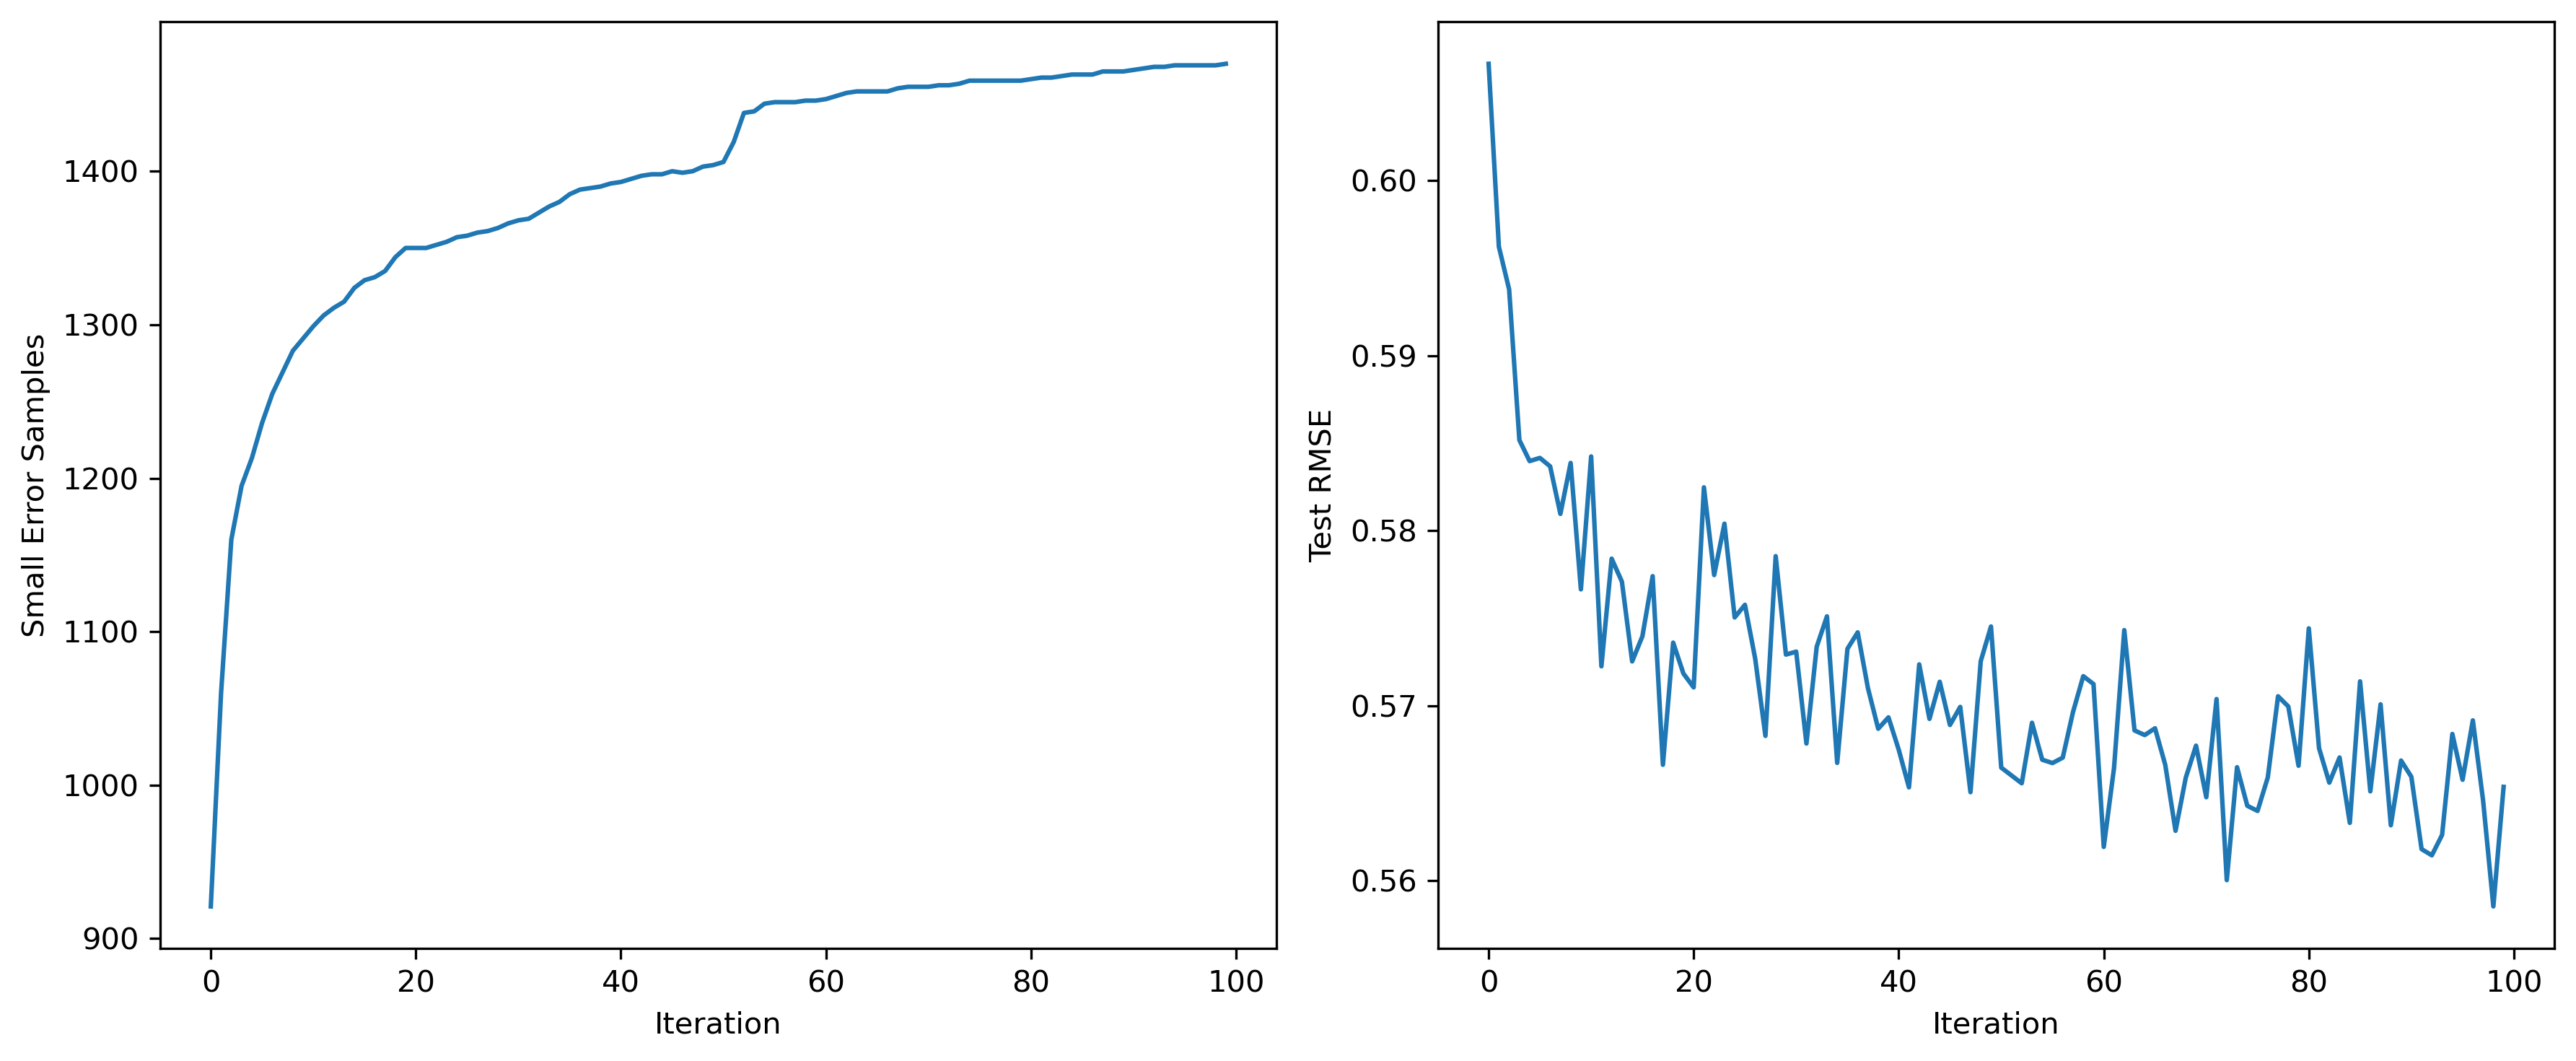

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot([m['iteration'] for m in iteration_metrics], 
         [m['small_error_samples'] for m in iteration_metrics])
plt.xlabel('Iteration')
plt.ylabel('Small Error Samples')
plt.subplot(1, 2, 2)
plt.plot([m['iteration'] for m in iteration_metrics], 
         [m['test_rmse'] for m in iteration_metrics])
plt.xlabel('Iteration')
plt.ylabel('Test RMSE')
plt.tight_layout()
# plt.savefig(os.path.join(file_path, 'iteration_metrics.png'))

####################################################################################################
[DFT - Self Learning XGBoost] Training Self Learning XGBoost on Mix data:
----------------------------------------------------------------------------------------------------
[Train_error] Evaluating Self Learning XGBoost on train set:


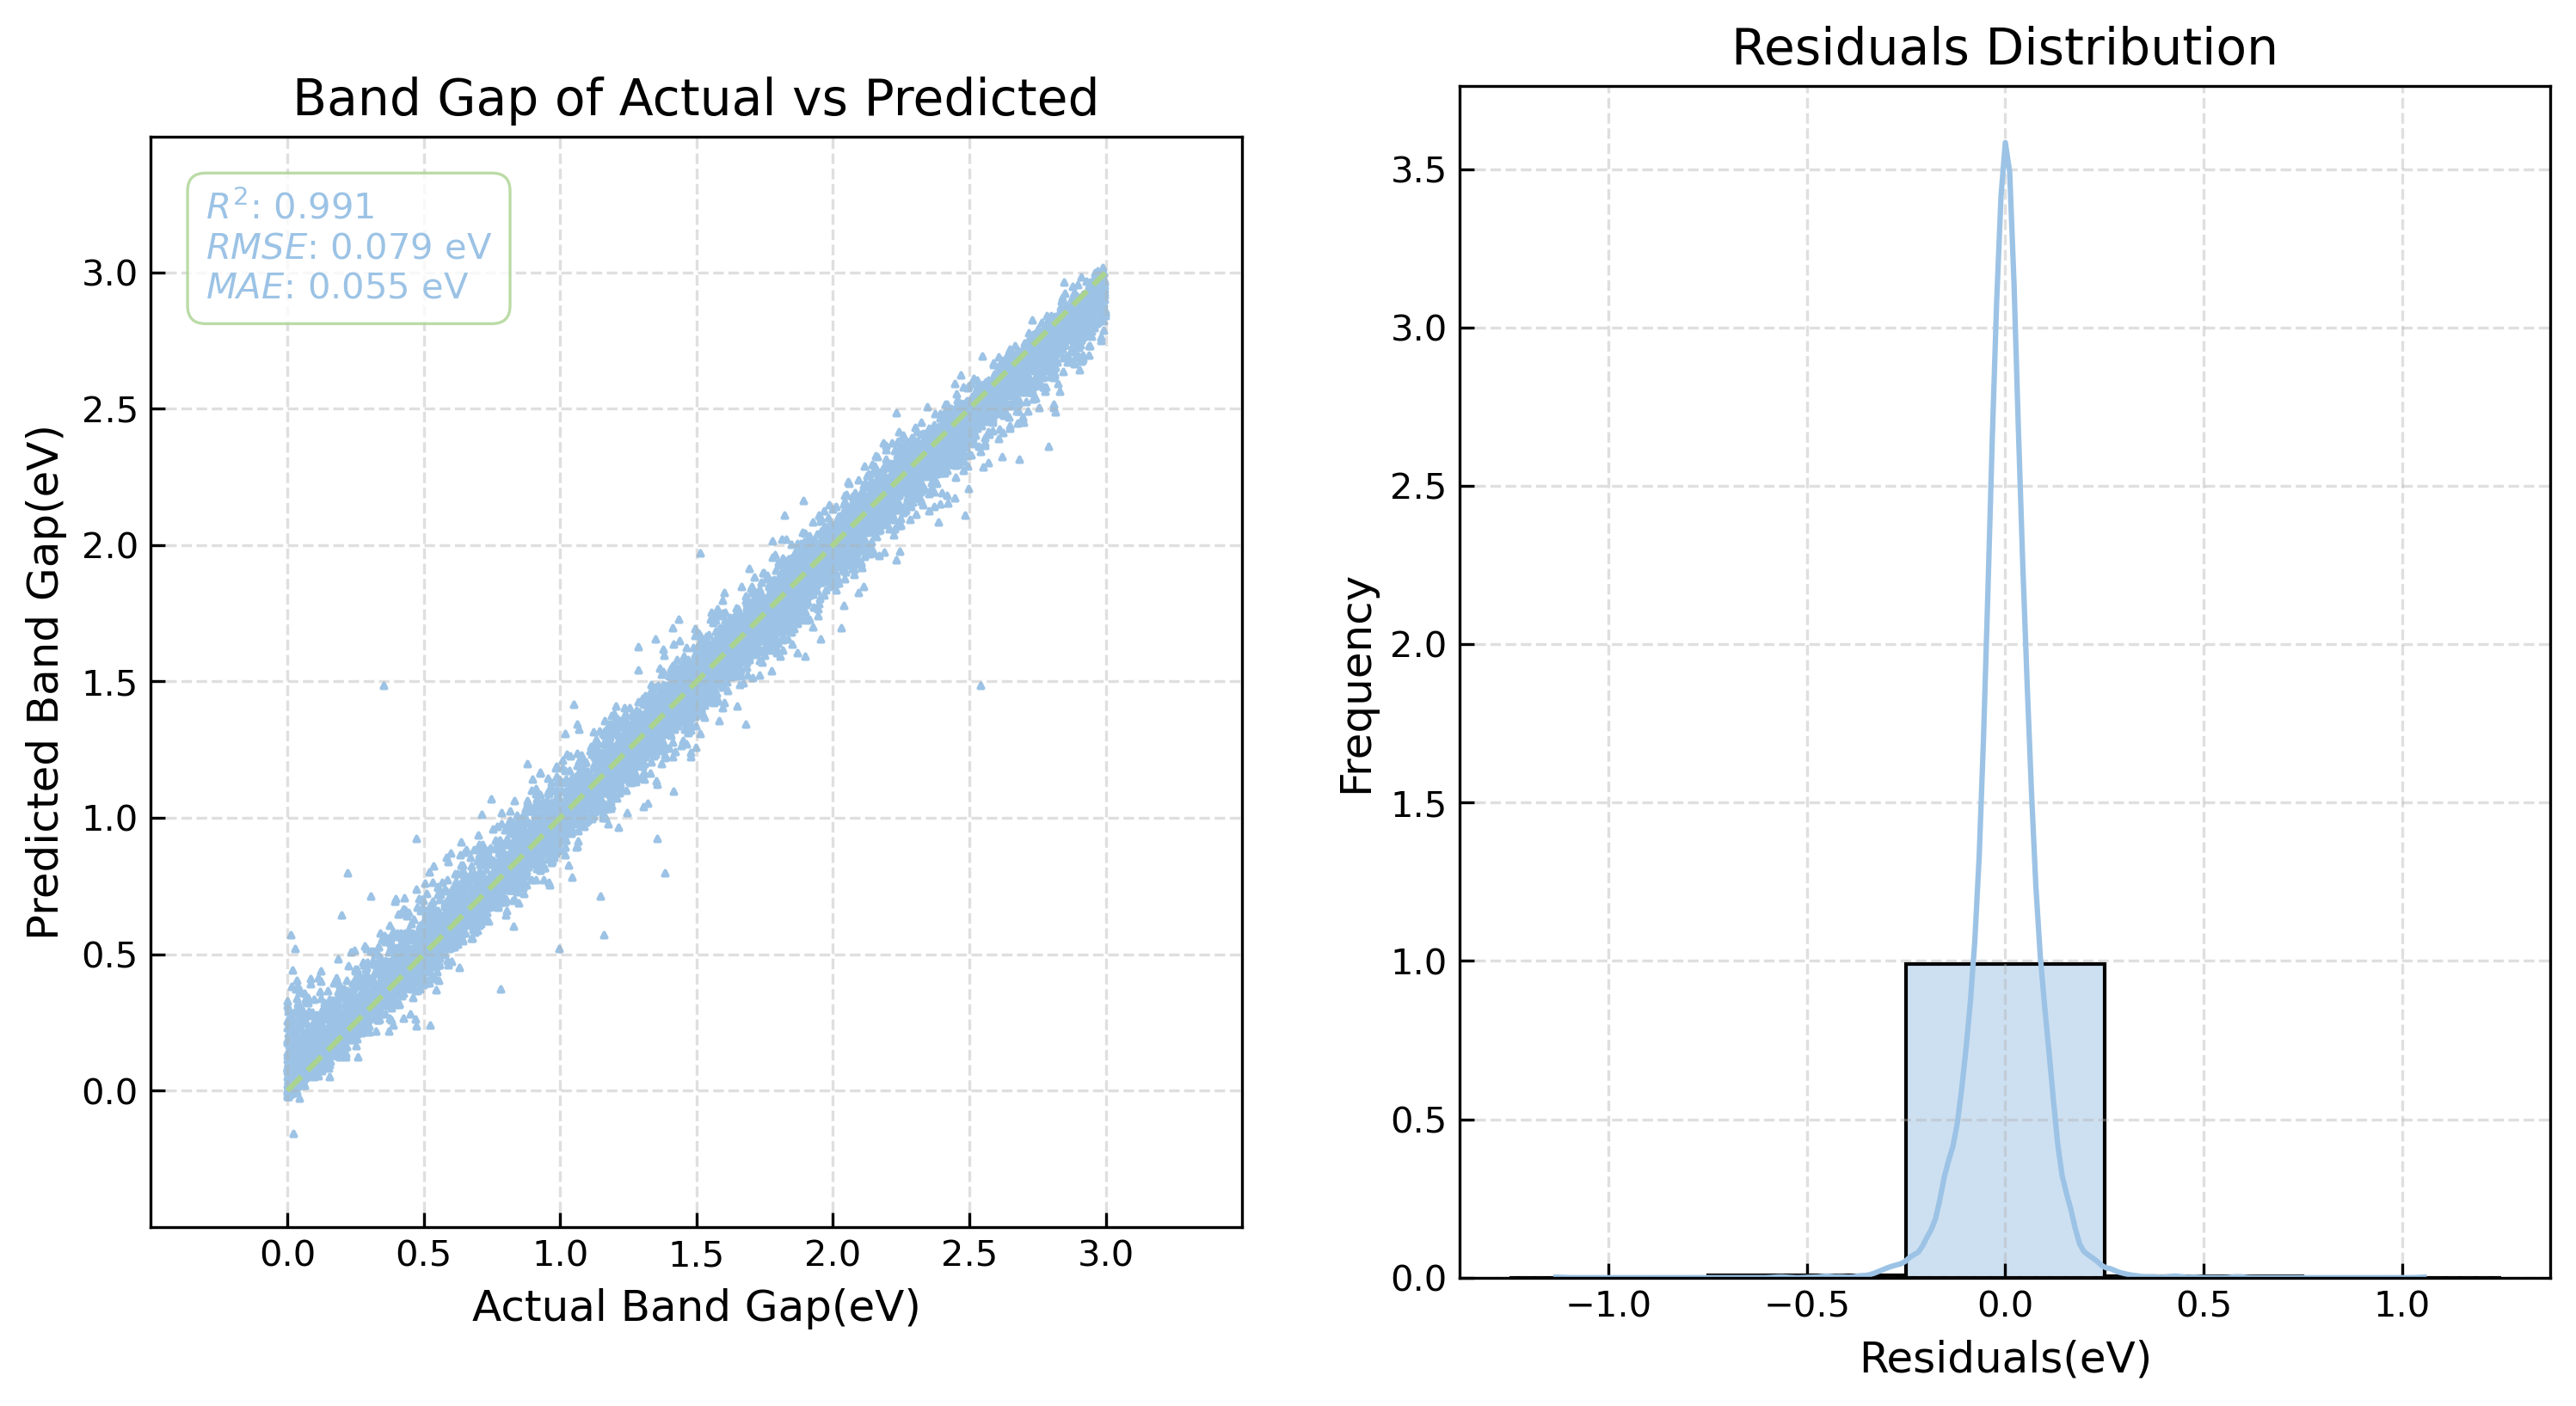


Model Evaluation Results:
Test set size: 9745
Test set: R²: 0.9914 RMSE: 0.0791 MAE: 0.0553 MAPE: 207.5975%
[Test MIX -> DFT] Evaluating Self Learning XGBoost on DFT test set:


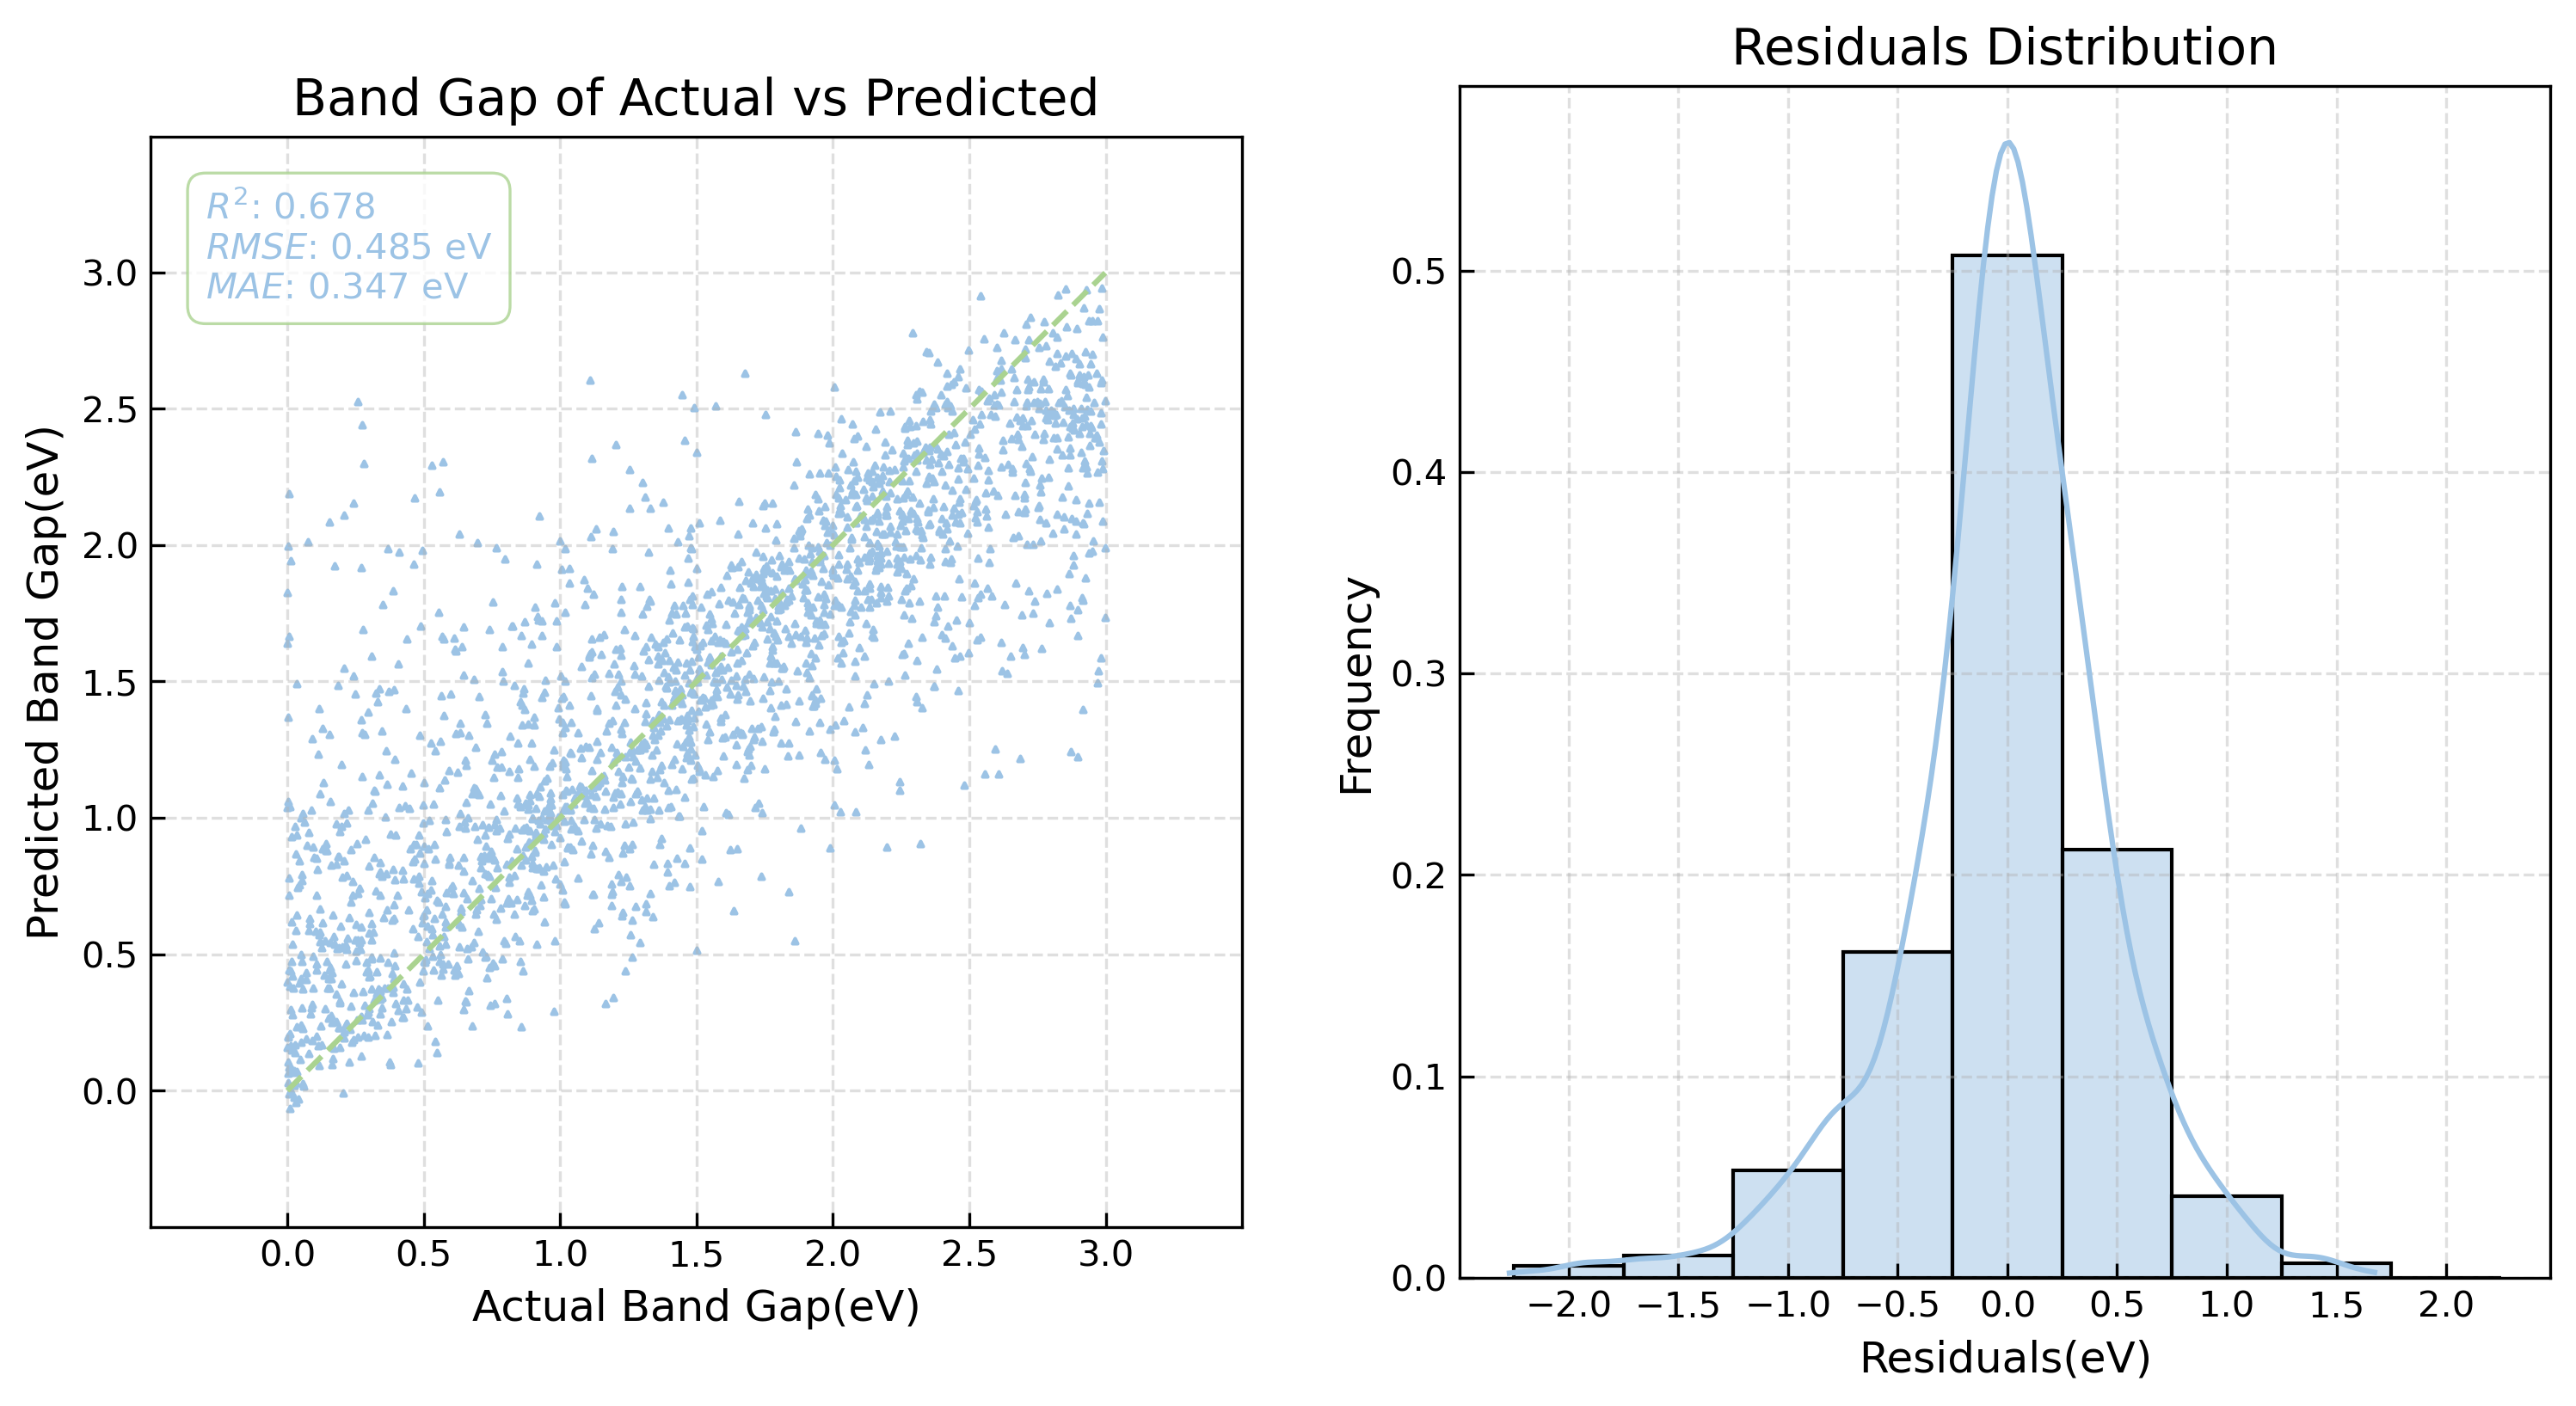


Model Evaluation Results:
Test set size: 2067
Test set: R²: 0.6785 RMSE: 0.4853 MAE: 0.3473 MAPE: 918.6841%
[Test MIX -> EXP] Evaluating Self Learning XGBoost on EXP test set:


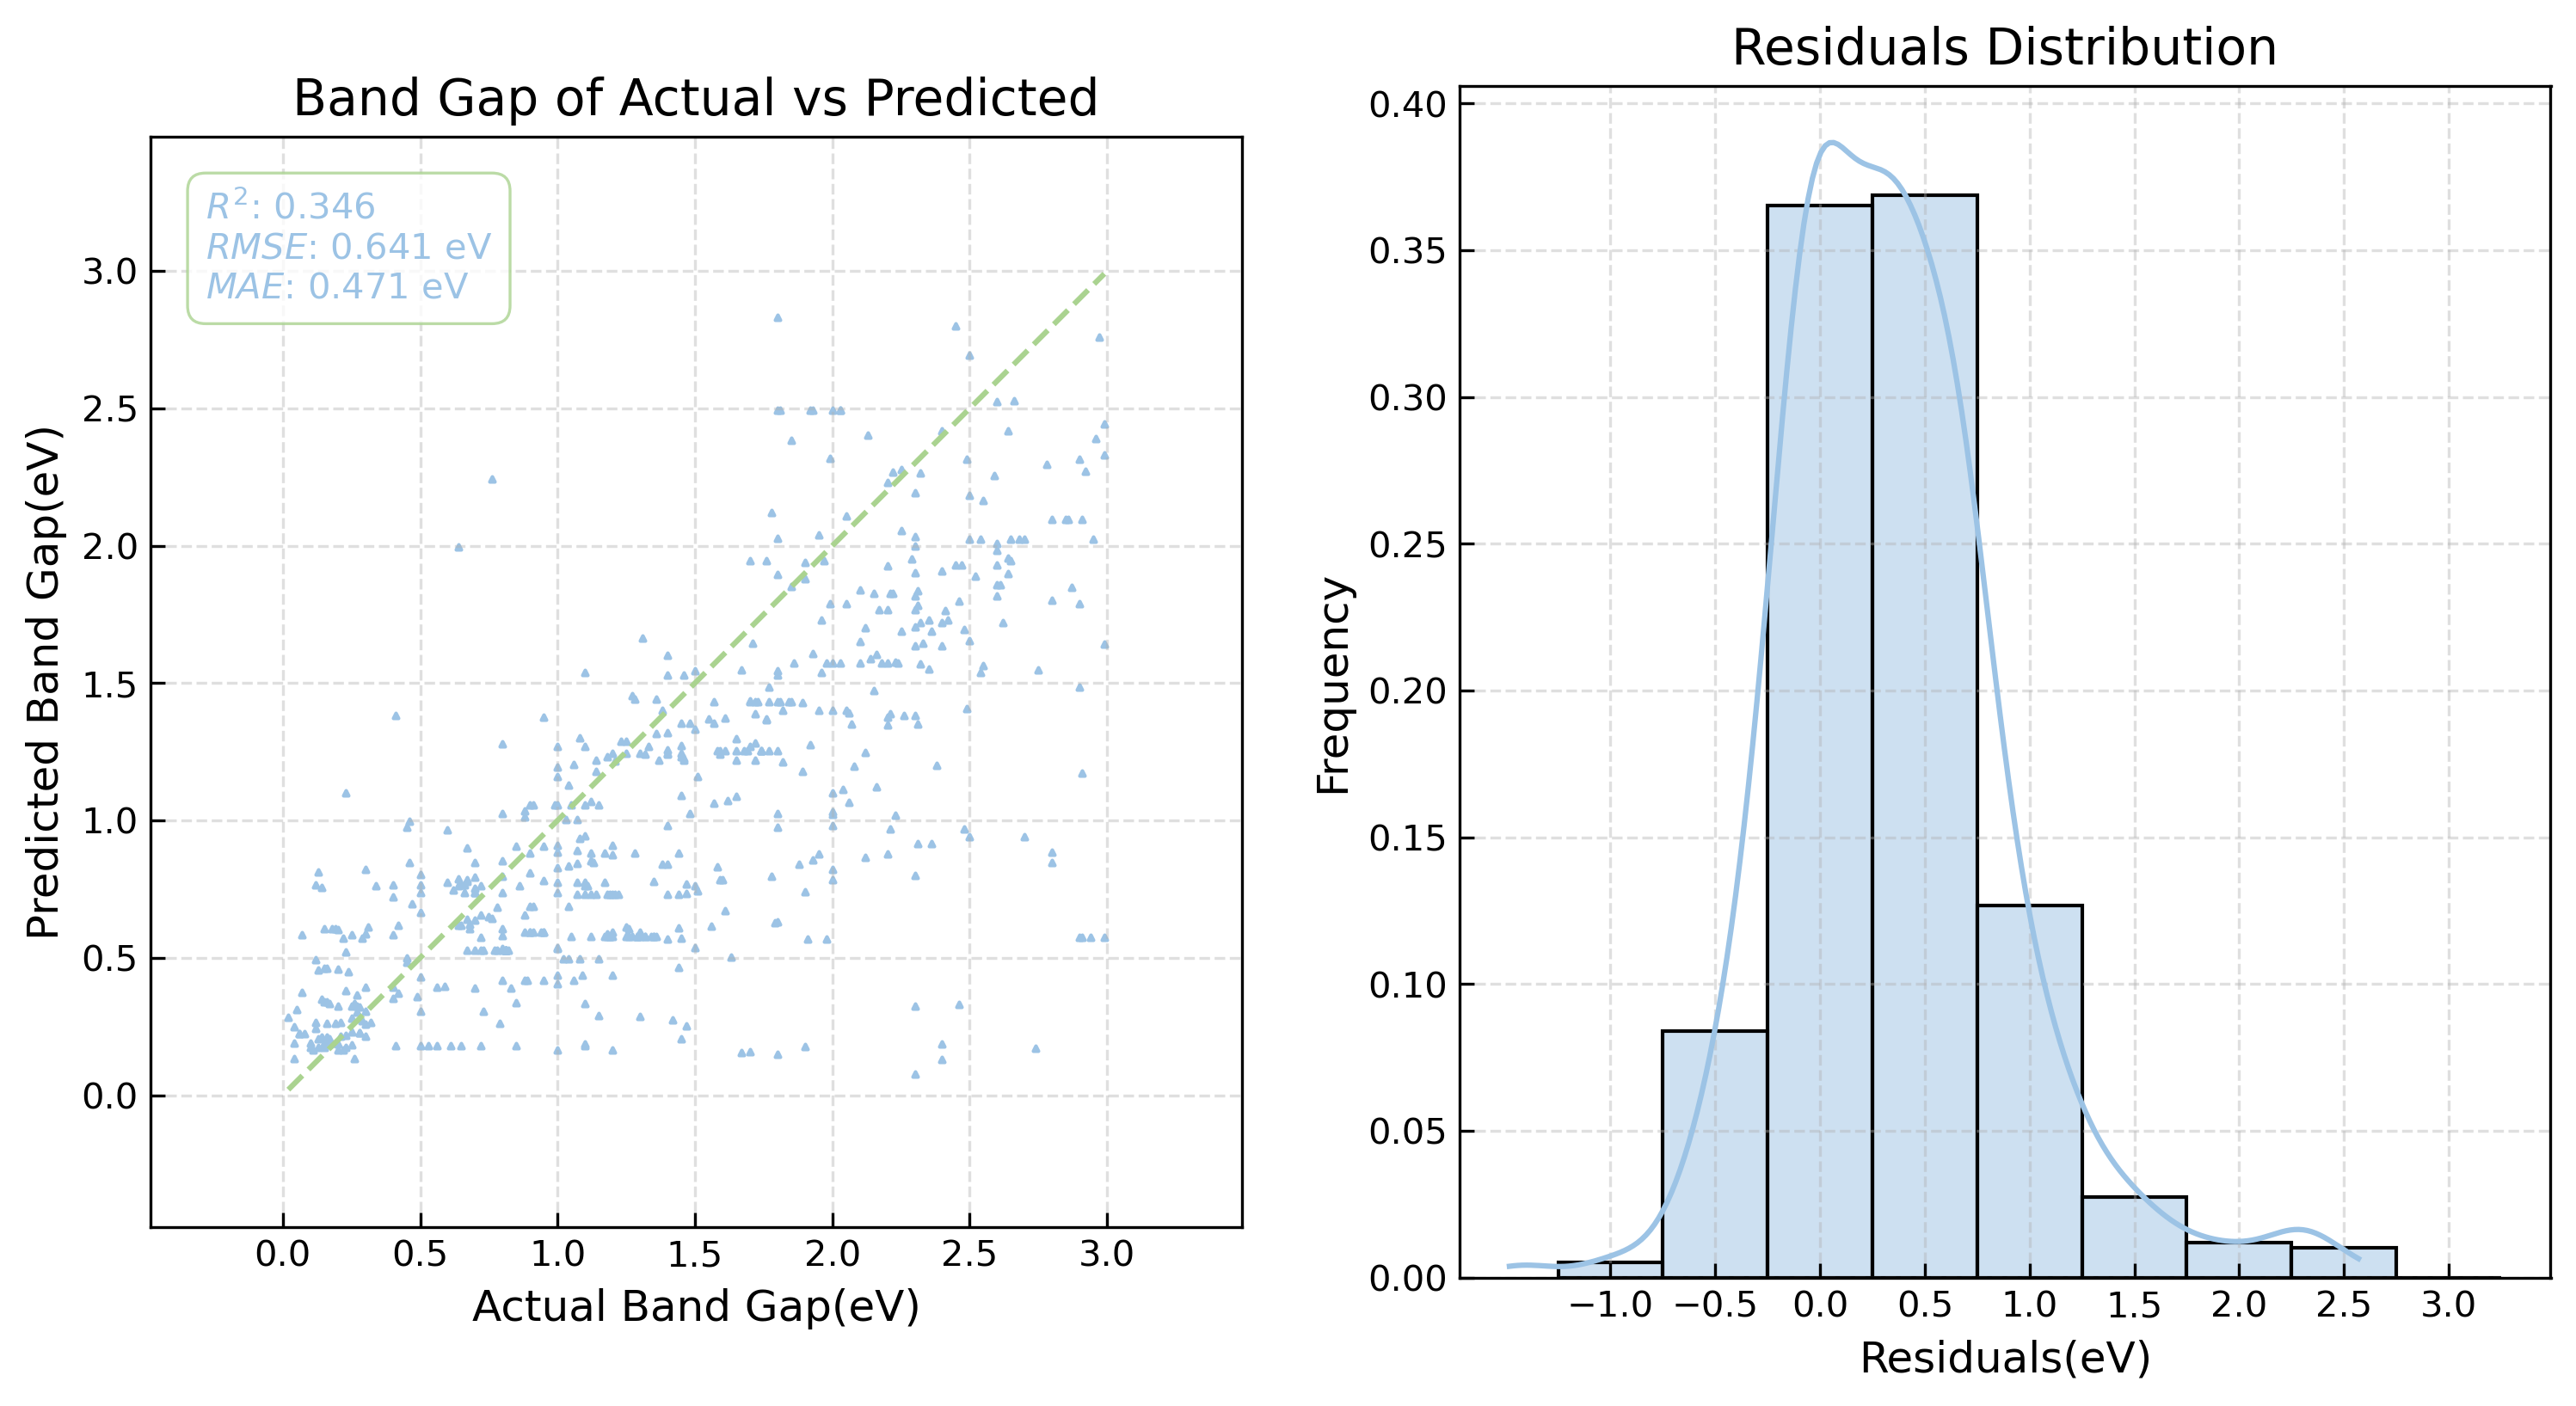


Model Evaluation Results:
Test set size: 585
Test set: R²: 0.3461 RMSE: 0.6409 MAE: 0.4708 MAPE: 49.3825%
[Test MIX -> MIX] Evaluating Self Learning XGBoost on mixed test set:


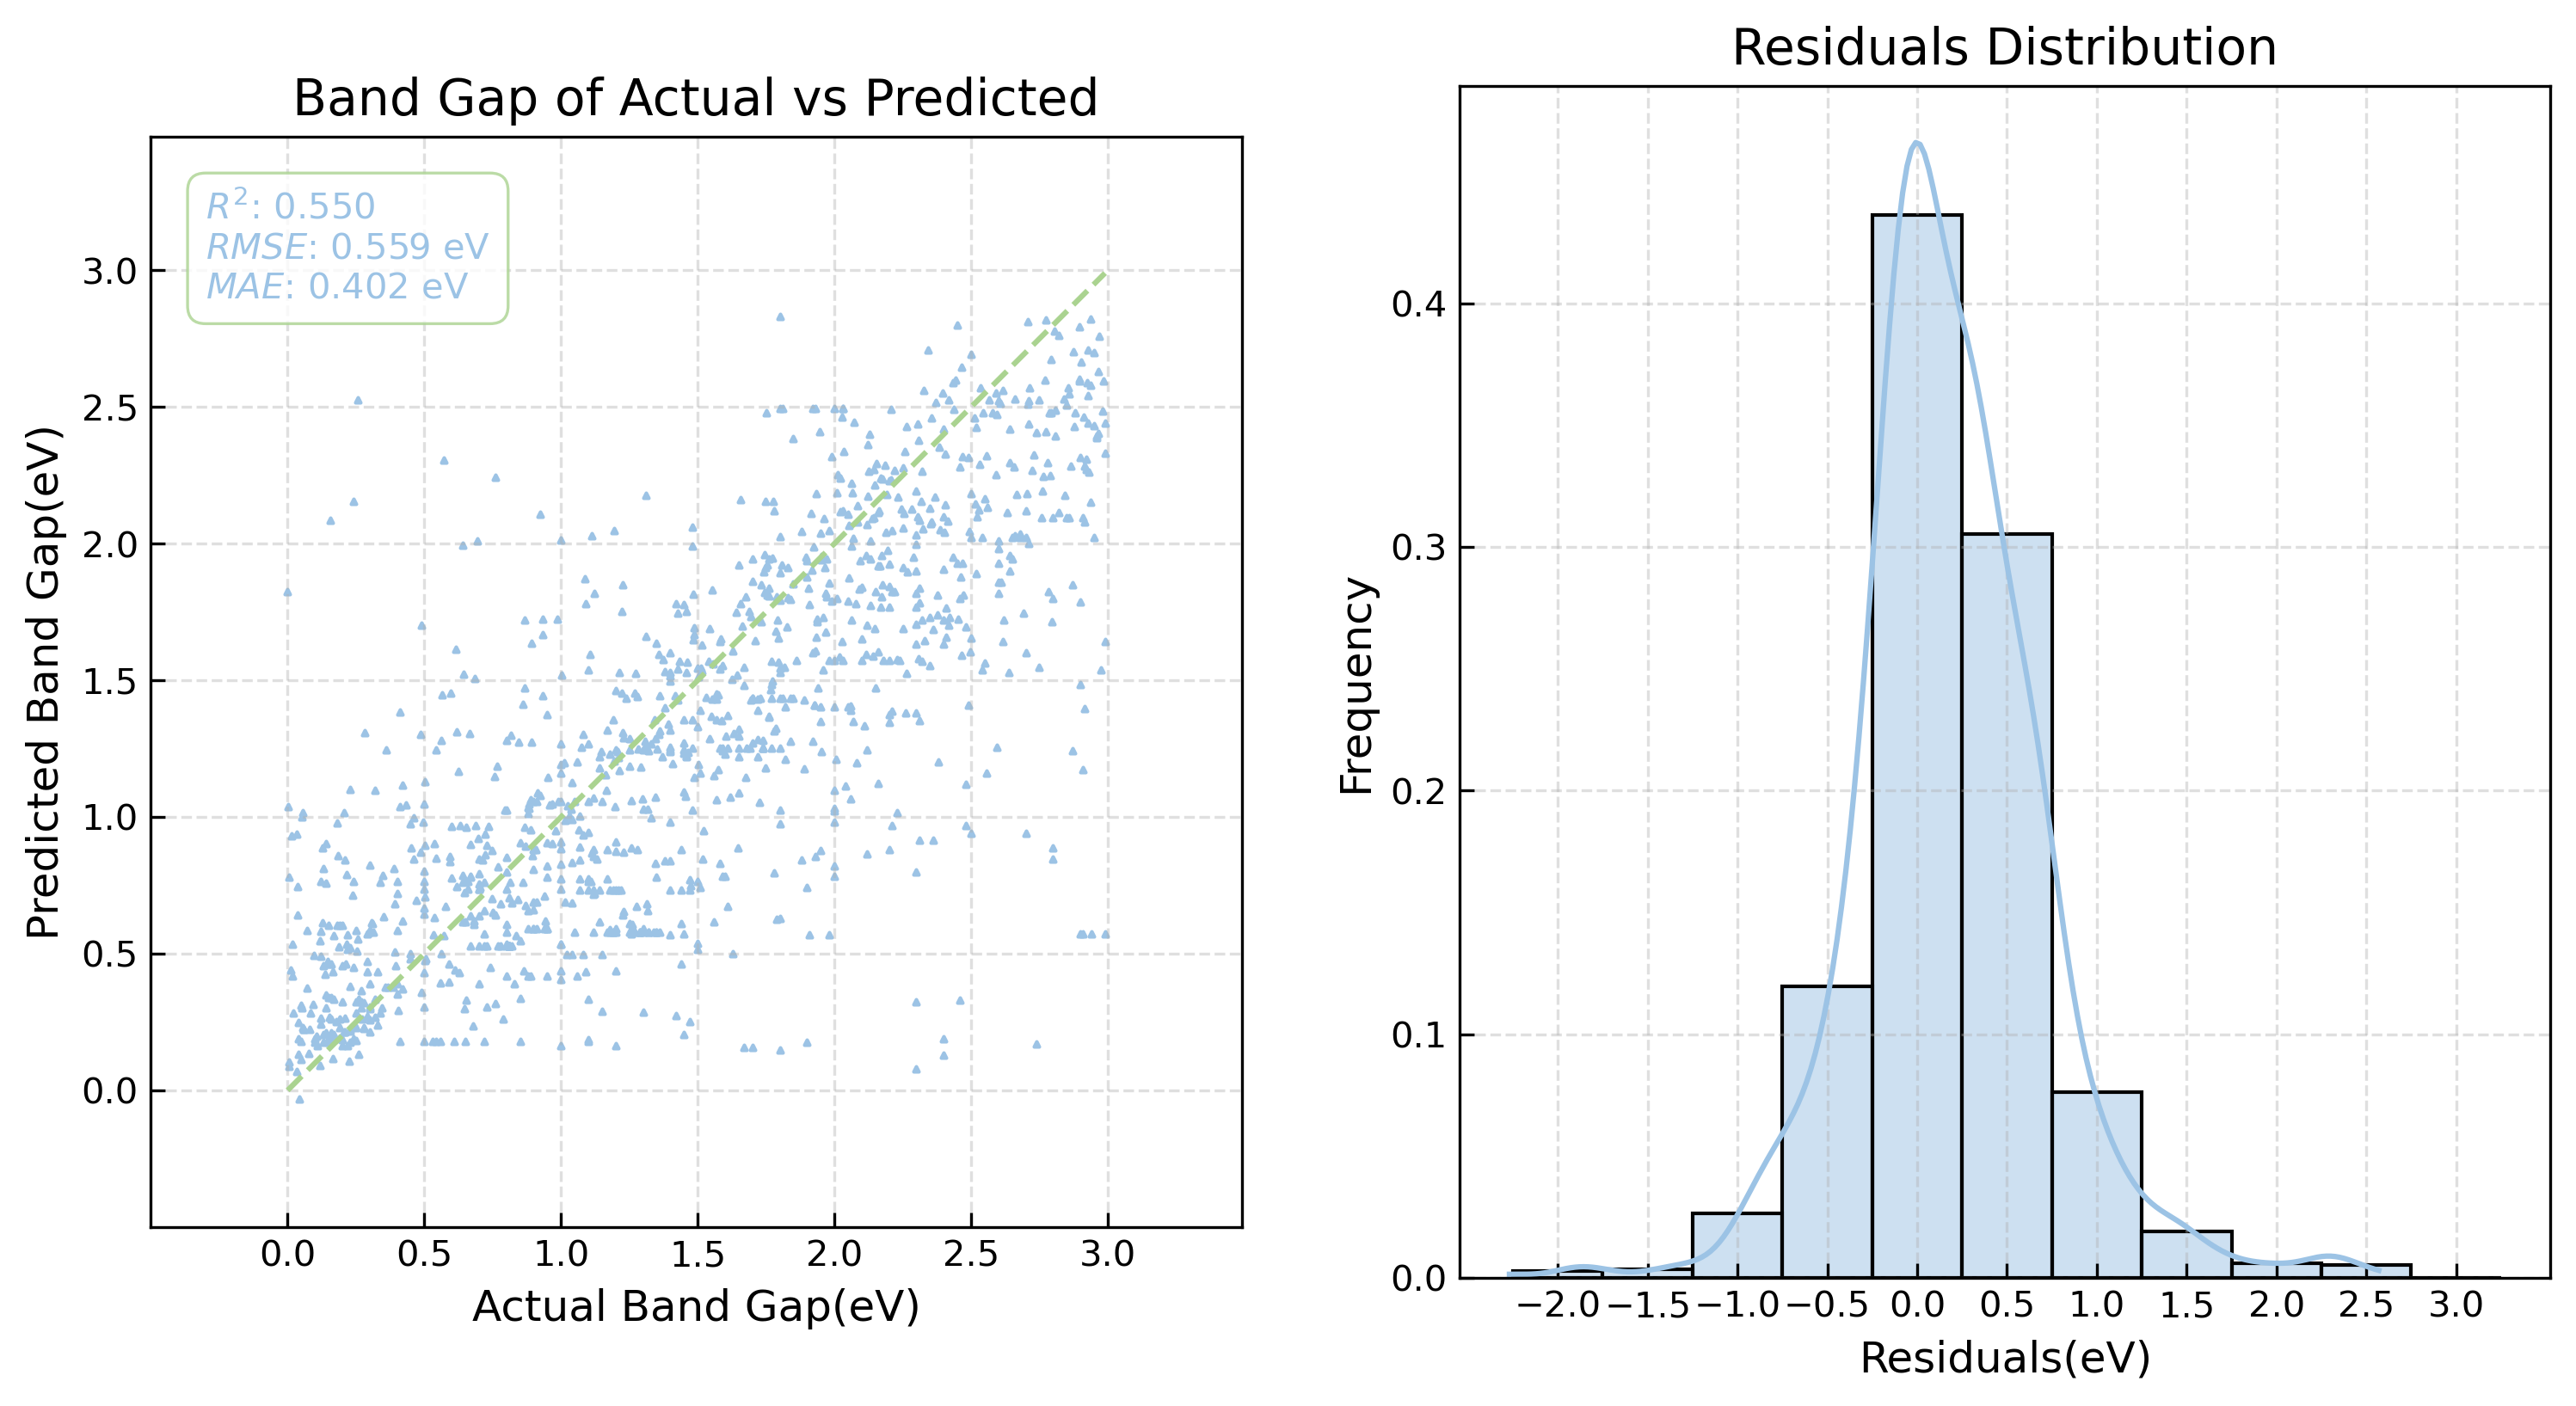


Model Evaluation Results:
Test set size: 1170
Test set: R²: 0.5500 RMSE: 0.5585 MAE: 0.4024 MAPE: 936.6269%


,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Self Learning XGBoost,Train,mix,mix,0.991355,0.079097,0.055258
1,Self Learning XGBoost,Test,mix,dft,0.678495,0.485335,0.347344
2,Self Learning XGBoost,Test,mix,exp,0.346095,0.640931,0.470766
3,Self Learning XGBoost,Test,mix,mix,0.550038,0.558519,0.402406


In [70]:
# 
MODEL_NAME = 'Self Learning XGBoost'
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on mixed data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on Mix data:")
print("-" * 100)

model = best_model

# evaluate on the train set
print(f"[Train_error] Evaluating {MODEL_NAME} on train set:")
metrics = model.evaluate(train_X, train_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test MIX -> DFT] Evaluating {MODEL_NAME} on DFT test set:")

metrics = model.evaluate(dft_test_X, dft_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# evaluate on the exp test set
print(f"[Test MIX -> EXP] Evaluating {MODEL_NAME} on EXP test set:")
metrics = model.evaluate(exp_test_X, exp_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'exp',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the mixed test set
print(f"[Test MIX -> MIX] Evaluating {MODEL_NAME} on mixed test set:")
metrics = model.evaluate(mixed_test_X, mixed_test_y)
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,    
'Error_Type': 'Test',
'Train_set': 'mix',
'Test_set': 'mix',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}
# save the model metrics to a csv file
model_metrics.to_csv(os.path.join('./metrics', 'self_learning_metrics.csv'), index=False)
model_metrics

**Compare to direct mix:**
- the self-learning model has a better performance on the **exp test set**, 
- but the performance on the dft test set is not as good as the direct mix model.

- Sampled dft train data model is not good as the total dft train data model.